In [29]:
import os
import librosa
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [30]:
def initial_load(audio_path):
    audio_files = []
    transcripts = []
    
    for audio_file in os.listdir(audio_path):
        audio, sr = librosa.load(os.path.join(audio_path, audio_file), sr=None)
        audio_files.append(audio)
        transcripts.append(audio_file.replace('.mp3', ''))
    
    return audio_files, sr, np.array(transcripts)

In [65]:
def augment_pitch_shift(audio_files, transcripts, sr, pitch_shift_steps):
    audio_files_pitched = []
    transcripts_modified = []
    
    for index, audio_file in enumerate(audio_files):
        audio_pitch_shifted = librosa.effects.pitch_shift(audio_file, sr, pitch_shift_steps)
        audio_files_pitched.append(audio_pitch_shifted)
        transcripts_modified.append(transcripts[index] + ' SHIFTED')
        
    return audio_files_pitched, transcripts_modified
    

In [56]:
def augment_noise(audio_files, transcripts, sr, noise_constant = 0.005):
    audio_files_noised = []
    transcripts_modified = []
    
    for index, audio_file in enumerate(audio_files):
        audio_noised = audio_file + noise_constant * np.random.normal(0, 1, len(audio_file))
        audio_files_noised.append(audio_noised)
        transcripts_modified.append(transcripts[index] + ' NOISED')
        
    return audio_files_noised, transcripts_modified

In [57]:
def spectrogram_cast(audio_files):
    spectrograms = []
    
    for audio_file in audio_files:
        spectrogram = librosa.feature.melspectrogram(y=audio_file)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)  
        spectrograms.append(spectrogram)
        
    return spectrograms

In [58]:
def spectrograms_normalization(spectrograms, max_length=None):
    spectrograms_normalized = []
    if(max_length==None):
        max_length = max(spec.shape[1] for spec in spectrograms)
    
    for i in range(len(spectrograms)):
        spectrogram_empty = np.zeros((128, max_length))
        spectrogram_empty[:, :spectrograms[i].shape[1]] = spectrograms[i]
        spectrograms_normalized.append(spectrogram_empty)
        
    return spectrograms_normalized

In [59]:
def spectrograms_plot(spectrograms, transcripts, cols, sr, name='spectrograms.png', limit=2):
    plt.figure(figsize=(15, 10))
    num_spec = min(limit, len(spectrograms))
    num_cols = cols  
    num_rows = (num_spec - 1) // num_cols + 1 
    
    for i in range(num_spec):
        plt.subplot(num_rows, num_cols, i + 1)
        librosa.display.specshow(spectrograms[i], sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(transcripts[i])

    plt.tight_layout()
    plt.savefig(name)
    plt.show()

In [75]:
def input_preprocess_train(transcripts, *spectrograms_arrays):
    
    print(len(spectrograms_arrays))
    
    spectrograms = []
    output_transcripts = []
    
    label_encoder = LabelEncoder()
    encoded_transcripts = label_encoder.fit_transform(transcripts)
    
    for spectrogram_array in spectrograms_arrays:
        print(len(spectrogram_array))
        for index, spectrogram in enumerate(spectrogram_array):
            spectrograms.append(spectrogram/255.0)
        output_transcripts.extend(encoded_transcripts)
        print('extend')
            
    return np.array(spectrograms), np.array(output_transcripts), label_encoder

In [61]:
def input_preprocess_test(transcripts, *spectrograms_arrays):
    spectrograms = []
        
    for spectrogram_array in spectrograms_arrays:
        for index, spectrogram in enumerate(spectrogram_array):
            spectrograms.append(spectrogram/255.0)
            
    return np.array(spectrograms)

In [62]:
audio_path = 'initial phrases voiced'

audio_files, sr, transcripts = initial_load(audio_path)

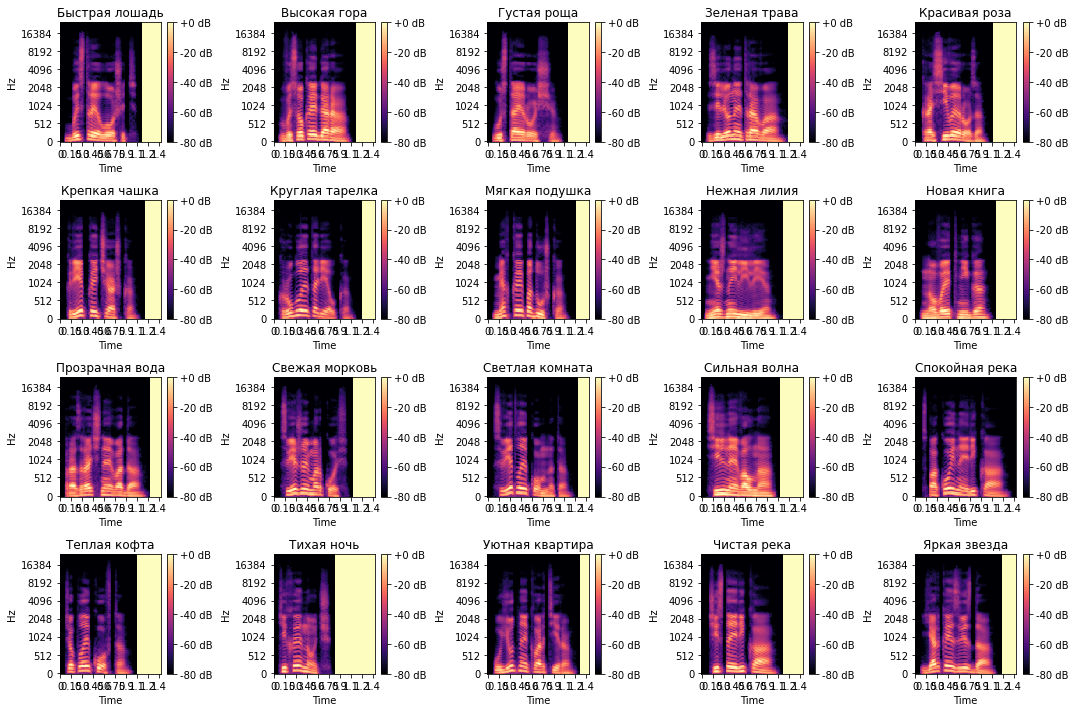

In [63]:
spectrograms_default = spectrogram_cast(audio_files)
spectrograms_default_normalized = spectrograms_normalization(spectrograms_default)
spectrograms_plot(spectrograms_default_normalized, transcripts, 5, sr, 'spectrograms_default.png', 20)

<ipython-input-65-31674f5951a0>:6: FutureWarning: Pass sr=48000, n_steps=2 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_pitch_shifted = librosa.effects.pitch_shift(audio_file, sr, pitch_shift_steps)


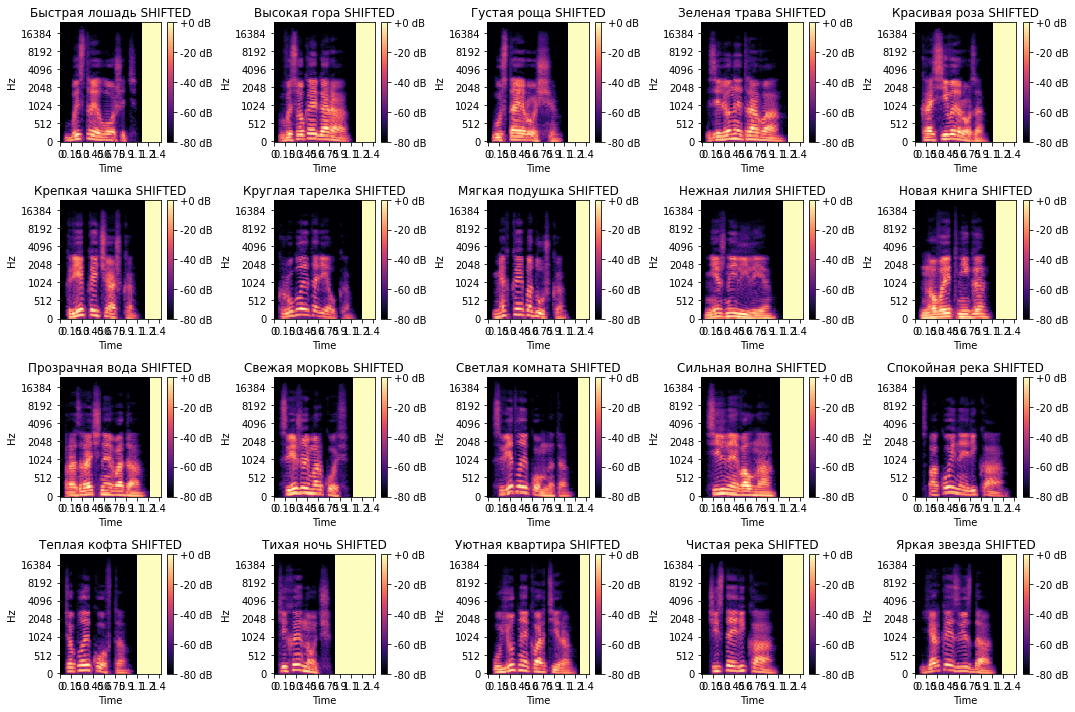

In [66]:
audio_files_pitch_shifted, transcripts_pitch_shifted = augment_pitch_shift(audio_files, transcripts, sr, 2)

spectrograms_pitch_shifted = spectrogram_cast(audio_files_pitch_shifted)
spectrograms_pitch_shifted_normalized = spectrograms_normalization(spectrograms_pitch_shifted)
spectrograms_plot(spectrograms_pitch_shifted_normalized, transcripts_pitch_shifted, 5, sr, 'spectrograms_pitch_shifted.png', 20)

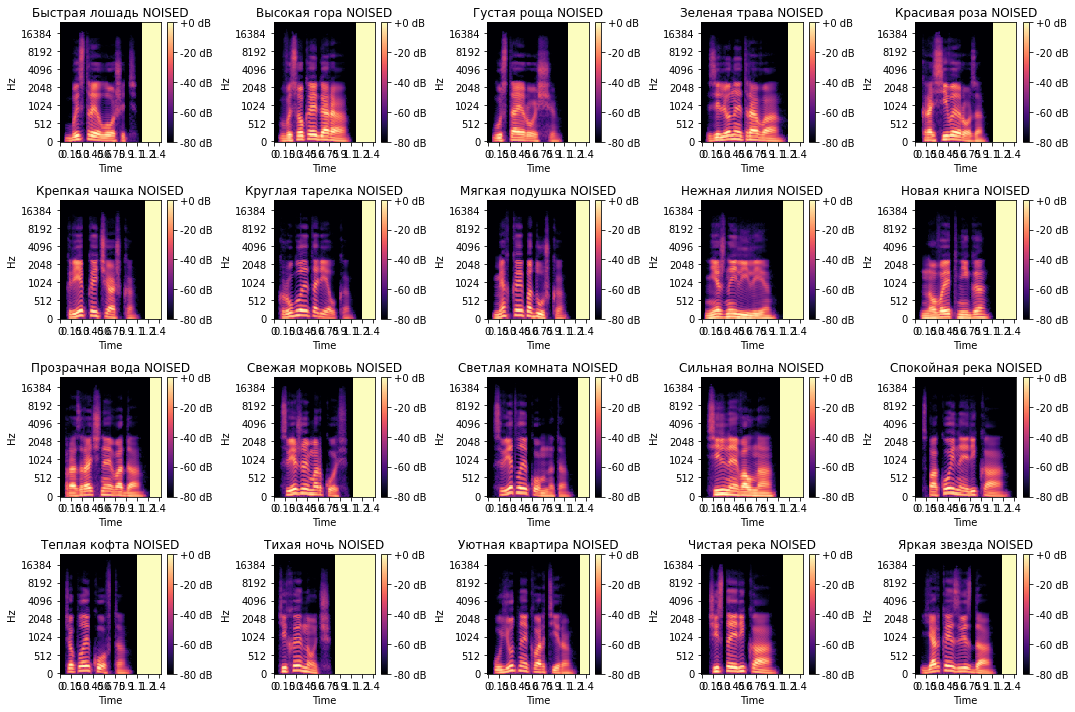

In [205]:
audio_files_noised, transcripts_noised = augment_noise(audio_files, transcripts, sr, 0)

spectrograms_noised = spectrogram_cast(audio_files_noised)
spectrograms_noised_normalized = spectrograms_normalization(spectrograms_noised)
spectrograms_plot(spectrograms_noised_normalized, transcripts_noised, 5, sr, 'spectrograms_noised.png', 20)

In [206]:
audio_test_path = 'cross phrases voiced'
audio_files_test, sr, transcripts_test = initial_load(audio_test_path)

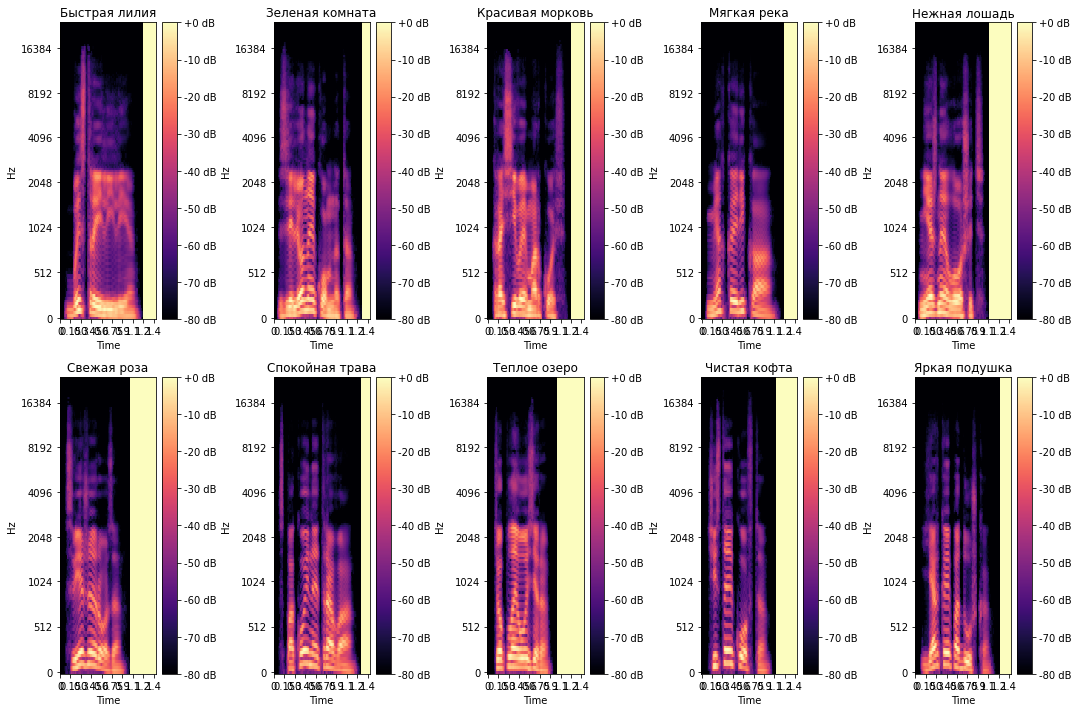

In [207]:
spectrograms_test = spectrogram_cast(audio_files_test)
spectrograms_test_normalized = spectrograms_normalization(spectrograms_test, 130)
spectrograms_plot(spectrograms_test_normalized, transcripts_test, 5, sr, 'spectrograms_test.png', 10)

In [259]:
X, y, label_encoder = input_preprocess_train(transcripts, spectrograms_default_normalized, spectrograms_pitch_shifted_normalized, spectrograms_noised_normalized)

3
20
extend
20
extend
20
extend


In [275]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

In [276]:
X_train.shape

(30, 128, 130)

In [315]:
# Создание модели CTC
model = models.Sequential()
model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (2, 2), activation='relu', padding="same", strides=1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (1, 1), activation='relu', padding="same", strides=1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (2, 2), activation='relu', padding="same", strides=1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(62, activation='relu'))
model.add(layers.Dense(len(np.unique(y_train)) + 1, activation='softmax'))  # +1 для учета пустого символа в CTC

# Компиляция модели
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Обучение модели с использованием валидационной выборки
history = model.fit(X_train, y_train, epochs=30, batch_size=1, verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
30/30 [==============================] - 1s 15ms/step - loss: 3.0366 - accuracy: 0.0000e+00 - val_loss: 3.0058 - val_accuracy: 0.0667
Epoch 2/30
30/30 [==============================] - 0s 10ms/step - loss: 2.9864 - accuracy: 0.1000 - val_loss: 3.0051 - val_accuracy: 0.0667
Epoch 3/30
30/30 [==============================] - 0s 12ms/step - loss: 2.9658 - accuracy: 0.1000 - val_loss: 3.0234 - val_accuracy: 0.0333
Epoch 4/30
30/30 [==============================] - 0s 10ms/step - loss: 2.9934 - accuracy: 0.1000 - val_loss: 3.0533 - val_accuracy: 0.0667
Epoch 5/30
30/30 [==============================] - 0s 10ms/step - loss: 2.9373 - accuracy: 0.1333 - val_loss: 3.0407 - val_accuracy: 0.0667
Epoch 6/30
30/30 [==============================] - 0s 10ms/step - loss: 2.8690 - accuracy: 0.1000 - val_loss: 3.0700 - val_accuracy: 0.0667
Epoch 7/30
30/30 [==============================] - 0s 11ms/step - loss: 2.7688 - accuracy: 0.1667 - val_loss: 2.9642 - val_accuracy: 0.0333
Epoch 8/3

In [316]:
X_test = input_preprocess_test(transcripts_test, spectrograms_test_normalized)
print(transcripts_test)

['Быстрая лилия' 'Зеленая комната' 'Красивая морковь' 'Мягкая река'
 'Нежная лошадь' 'Свежая роза' 'Спокойная трава' 'Теплое озеро'
 'Чистая кофта' 'Яркая подушка']


In [317]:
predictions = model.predict(X_test)


1/1 [==============================] - 0s 141ms/step


In [318]:
print(transcripts_test)

['Быстрая лилия' 'Зеленая комната' 'Красивая морковь' 'Мягкая река'
 'Нежная лошадь' 'Свежая роза' 'Спокойная трава' 'Теплое озеро'
 'Чистая кофта' 'Яркая подушка']


In [319]:
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)


combined_transcripts = np.concatenate((transcripts, transcripts_test), axis=0)

label_encoder.fit(combined_transcripts)
encoded_transcripts_test = label_encoder.transform(transcripts_test)
test_loss, test_accuracy = model.evaluate(X_test, encoded_transcripts_test, verbose=1)

    
predicted_labels_text = label_encoder.inverse_transform(predicted_labels)
print(predicted_labels_text)

[19 17  6 19 13 11 17 11  2  6]
1/1 [==============================] - 0s 137ms/step - loss: nan - accuracy: 0.2000
['Сильная волна' 'Свежая роза' 'Красивая морковь' 'Сильная волна'
 'Нежная лошадь' 'Мягкая река' 'Свежая роза' 'Мягкая река' 'Высокая гора'
 'Красивая морковь']
